### Introduction
In this template we use random subsampling validation to predict an entire distribution of some target variable, thereby providing a generic way to compute a prediction interval. This method can be combined with any (machine learning) algorithm of choice. The method relies on the assumptions that (i) new realizations of the modelled target variable are normally distributed around the predicted values of some regression model and that (ii) the standard devation from this distribution can be estimated by using the available features in the data. 

In this template we use RandomForestRegressor as our algorithm. But in principle any other algorithm suited for regression could be used. 

#### Imports

In [1]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from scipy import stats
from utils import generate_plot
import seaborn as sns

### Load data

In this example, we will use a dataset that describes different types of concrete. We use various characteristics of the types of concrete to predict the strength of the final product. This repository also contains two other famous datasets that can be used to validate the accuracy of the methodology.  

In [2]:
random_seed = 7
np.random.seed(random_seed)

data = pd.read_csv("data/concrete.csv")

target = "strength"
features = data.columns[data.columns != target]

#### Train-test split

In order to validate the accuracy of our proposed methodology, we split data in a train and test set. Note that in the datasets that are used in the repository, we can do a random train-test split. However, in a lot of cases this is not appriopriate way to validate accuracy. For example, if there is a clear time component in the dataset, using a time-based train-test split will probably lead to a more accurate representation of real-world performance.

In [3]:
n_observations = len(data)

size_test = int(n_observations*0.2)
ind_test = np.random.choice(data.index, size = size_test, replace = False)

train = data.drop(ind_test)
test = data.loc[ind_test]

#### Specify parameters

Each prediction interval has an associated confidence level that quantifies the desired probability with which the target value of a new observation lies in the calculated prediction interval. In this template we use a confidence level of 95%. 


In [4]:
number_of_validation_rounds = 50 
confidence_level = 0.95

### Generate dataset

Now we will use the random subsampling validation to obtain an array of squared residuals, so that we can quantify how far observations will approximately deviate from their predicted values. We will eventually use this array of residuals to estimate an observation-specific standard devation. Again, the way we generate the validation sets needed to build our dataset is dependent on the structure of the data. In a lot of cases random splits between train and validation set may not lead to representatitive results. 


In [5]:
residuals_list = []
indices_list = []

size_validation_set = int(len(train)/10)

for i in range(number_of_validation_rounds):
    
    ind_valid = np.random.choice(train.index, size = size_validation_set, replace = False)
    
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X = train[features].drop(ind_valid), y = train[target].drop(ind_valid))

    pred_valid = model.predict(train[features].loc[ind_valid])
    residuals_valid = (pred_valid - train[target].loc[ind_valid])**2

    residuals_list = np.append(residuals_list, residuals_valid)
    indices_list = np.append(indices_list, ind_valid)

#### Training model that estimates standard deviation

We are now going to use all the squared residuals and the indices that we saved to build a model that can predict how far a prediction of our main model deviates from its true value, based on the set of features in our data. 

In [6]:
sd_estimator = RandomForestRegressor(n_estimators=100).fit(train[features].loc[indices_list], residuals_list)

#### Training our main model
Next thing to do is fitting our main model. Note that this should be the same model as was used to generate the residuals in the previous step. 

In [7]:
main_model = RandomForestRegressor(n_estimators=100).fit(X = train[features], y = train[target])

#### Generating predictions

Now it is time to generate predictions for observations in our test dataset. We use our main model to generate point predictions and we use our *sd_estimator* model to predict the deviation from the predicted value for each observation in order to obtain an observation-specific approximated standard deviation. 

In [8]:
predictions_test = main_model.predict(test[features])
std_test = np.sqrt(np.clip(sd_estimator.predict(test[features]), 0, np.inf))

#### Setting up prediction intervals

In order to calculate a prediction interval for each new observation, we use the approximated standard deviation for each observation in the test set and the assumption that the true realizations of our target variable are normally distributed around the predicted values obtained from our main model. 

In [9]:
t_value = stats.t.ppf(1 - (1-confidence_level)/2, size_test - 1)
upper_bound = predictions_test + t_value * std_test
lower_bound = predictions_test - t_value * std_test

results = pd.DataFrame({'upper_bounds': upper_bound, 'lower_bounds': lower_bound, 'actuals': test[target], 'predictions': predictions_test})

#### Validate results

Let's check what percentage of our observations in the test set fall within the computed prediction interval. This should be roughly equal to value of the parameter *confidence_level* that we have set. 

In [13]:
perc_observations_inside_interval = np.sum((results['actuals'] <= results['upper_bounds']) & (results['actuals'] >= results['lower_bounds']))/len(results)

print(f"Percentage of observations for which the actual value falls within computed prediction interval: {round(perc_observations_inside_interval*100,1)}%")

Percentage of observations for which the actual value falls within computed prediction interval: 94.2%


#### Visualize some predictions

We can also visually inspect some of the prediction intervals we have generated. The majority of the actual values should fall within computed prediction interval. 

<AxesSubplot:xlabel='Index', ylabel='Target variable'>

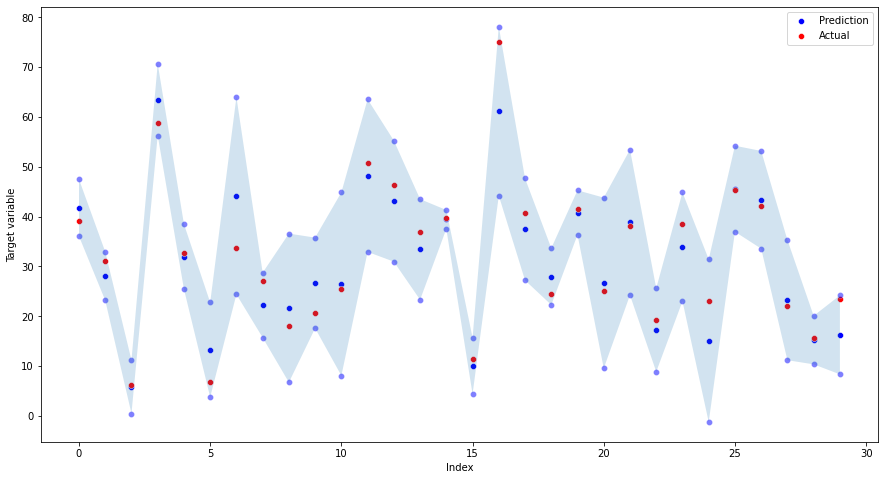

In [19]:
nr_observations = 30 

generate_plot(nr_observations, results)